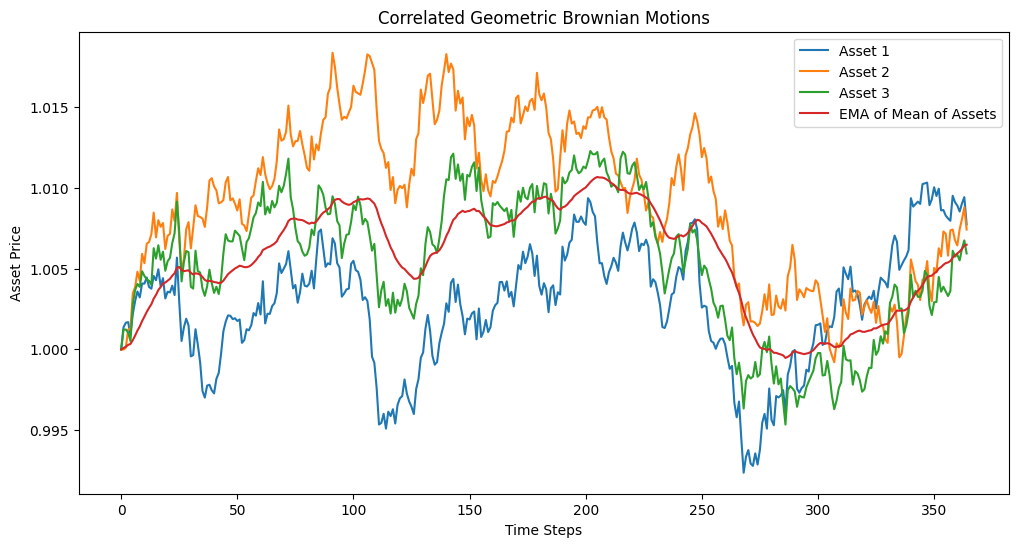

In [16]:

# Cholesky Decomposition
import numpy as np
import matplotlib.pyplot as plt

# Initialize parameters
n_assets = 3
n_steps = 365
dt = 0.01
mu = np.array([0,0,0])  # Drift for each asset
sigma = np.array([0.01, 0.01, 0.01])  # Volatility for each asset
S0 = np.array([1,1,1])  # Initial price for each asset
cor_matrix = np.array([[1.0, 0.6, 0.8], [0.6, 1.0, 0.8], [0.8, 0.6, 1.0]])

# Generate uncorrelated Brownian motions
dW = np.sqrt(dt) * np.random.randn(n_steps, n_assets)

# Apply Cholesky decomposition to get correlated Brownian motions
L = np.linalg.cholesky(cor_matrix)
dW_correlated = dW.dot(L.T)

# Initialize asset prices
S = np.zeros((n_steps, n_assets))
S[0] = S0

# Generate GBM paths
for t in range(1, n_steps):
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW_correlated[t])

# Plot the results
plt.figure(figsize=(12, 6))
for i in range(n_assets):
    plt.plot(S[:, i], label=f'Asset {i+1}')

ema_sum = np.zeros(S.shape[0])

# Set initial EMA to the sum of the initial values of all assets
ema_sum[0] = np.mean(S[0, :])

# Define the smoothing factor, assuming N=20 (for a 20-period EMA)
alpha = 2 / (20 + 1)

# Compute EMA of the sum of all assets
for t in range(1, S.shape[0]):
    ema_sum[t] = (1 - alpha) * ema_sum[t-1] + alpha * np.mean(S[t, :])

# Plot the EMA
plt.plot(ema_sum, label='EMA of Mean of Assets')

plt.title('Correlated Geometric Brownian Motions')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.legend()
plt.show()



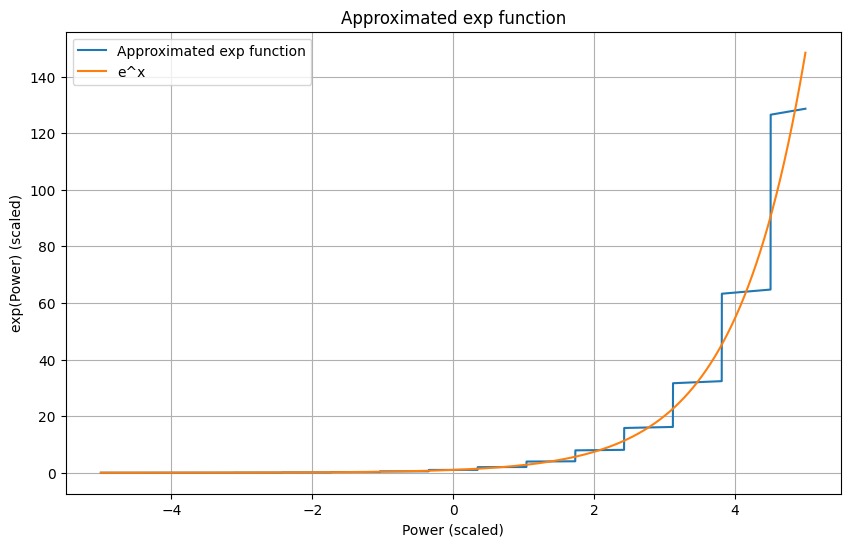

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def shift_function(result, shift_amount):
    if shift_amount >= 0: return int(result) << int(shift_amount)
    else: return int(result) >> int(-shift_amount)

def shift_function_simple(result, shift_amount):
    return result * ( 2 ** abs(shift_amount)) ** (shift_amount >= 0) * (1 / ( 2 ** abs(shift_amount))) ** (shift_amount < 0)


def exp_approx(power):
    power = power * 1e18
    if power <= -42139678854452767551: return 0
    if power >= 135305999368893231589: raise "exp overflow"
    x = (power * 2**96) // 10**18
    k = ((x * 2**96) // 54916777467707473351141471128 + 2**95) // 2**96
    x -= k * 54916777467707473351141471128
    p = (((x + 1346386616545796478920950773328) * x) // 2**96 + 57155421227552351082224309758442) * x + (4385272521454847904659076985693276 * 2**96)
    q = ((((x - 2855989394907223263936484059900) * x) // 2**96 + 50020603652535783019961831881945) * x) // 2**96 - 533845033583426703283633433725380
    q = (q * x) // 2**96 + 26449188498355588339934803723976023
    result = (p // q) * 3822833074963236453042738258902158003155416615667
    final_result = shift_function_simple(result, k - 195)
    return final_result/1e18

# Values of 'power' for plotting
power_values = np.linspace(-5, 5, 10000)
exp_values = [exp_approx(p) for p in power_values]
exp_actual = [np.exp(p) for p in power_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(power_values, exp_values, label='Approximated exp function')
plt.plot(power_values, exp_actual, label='e^x')
plt.xlabel('Power (scaled)')
plt.ylabel('exp(Power) (scaled)')
plt.title('Approximated exp function')
plt.grid(True)
plt.legend()
plt.show()


In [112]:
## V1 AggregateStablePrice

MAX_PAIRS = 10  # Set a default value for MAX_PAIRS
MIN_LIQUIDITY = 100  # Set a default value for MIN_LIQUIDITY
SIGMA = 1  # Set a default value for SIGMA

def exp(x):
    return 2.718281828459045 ** x  # A simple exp function for demonstration

def price(price_pairs):
    pool_liquidity = 0
    pool_liquidity_oracle_weighted = 0
    
    #### simplified away
    # oracle_prices = []
    # lp_share_prices = []
    # for price_pair in price_pairs:
    #     pool_supply = price_pair['pool']['totalSupply']
    #     if pool_supply >= MIN_LIQUIDITY:            
    #         oracle_price = price_pair['pool']['price_oracle']
    #         # @NOTE: we assume no inverse price_pairs here
    #         # if price_pair['is_inverse']: p = 10 ** 36 / p
    #         oracle_prices+=[oracle_price]
    #         lp_share_price = price_pair['pool']['get_virtual_price'] * price_pair['pool']['totalSupply']
    #         lp_share_prices+=[lp_share_price]
    #         pool_liquidity += lp_share_price
    #         pool_liquidity_oracle_weighted += lp_share_price * oracle_price
    
    # if pool_liquidity == 0: return 1
    # p_avg = pool_liquidity_oracle_weighted / pool_liquidity
    # error_vals = [((max(p_o, p_avg) - min(p_o, p_avg)) ** 2) / max(SIGMA ** 2, 1) for p_o in oracle_prices]
    # min_error = min(error_vals)
    
    # weighted_price_sum = 0
    # weight_sum = 0    
    # for i in range(len(lp_share_prices)):
    #     weight = lp_share_prices[i] * exp(-1 * (error_vals[i] - min_error))
    #     weight_sum += weight
    #     weighted_price_sum += weight * oracle_prices[i]
    
    # return weighted_price_sum / weight_sum
    ####
    #### simplified version
    valid_price_pairs = [price_pair for price_pair in price_pairs if price_pair['totalSupply'] >= MIN_LIQUIDITY]
    oracle_prices = [price_pair['price_oracle'] for price_pair in valid_price_pairs]
    lp_share_prices = [price_pair['get_virtual_price'] * price_pair['totalSupply'] for price_pair in valid_price_pairs]
    pool_liquidity = sum(lp_share_prices)
    pool_liquidity_oracle_weighted = sum([lp_share_prices[i] * oracle_prices[i] for i in range(len(valid_price_pairs))])
    if pool_liquidity == 0: return 1
    p_avg = pool_liquidity_oracle_weighted / pool_liquidity
    error_vals = [((max(p_o, p_avg) - min(p_o, p_avg)) ** 2) / max(SIGMA ** 2, 1) for p_o in oracle_prices]
    min_error = min(error_vals)
    
    weights = [lp_share_prices[i] * exp(-1 * (error_vals[i] - min_error)) for i in range(len(valid_price_pairs))]
    weight_sum = sum(weights)
    weighted_price_sum = sum([weights[i] * oracle_prices[i] for i in range(len(valid_price_pairs))])

    return weighted_price_sum / weight_sum

    #####    

# Example usage with dummy data
price_pairs = [
    {'totalSupply': 200, 'price_oracle': 100, 'get_virtual_price': 1, 'is_inverse': False},
    {'totalSupply': 150, 'price_oracle': 110, 'get_virtual_price': 1, 'is_inverse': False},
]

print(price(price_pairs))


100.00000468655993


In [136]:
## V2 AggregateStablePrice
import time

def exp(x: int) -> int:
    return int(2.718281828459045 ** x)  # example implementation, replace with your actual logic

def calc_ema_tvls(last_timestamp, price_pairs):
    current_timestamp = int(time.time())  # Assuming this is equivalent to block.timestamp

    if last_timestamp < current_timestamp: alpha = exp(-((current_timestamp - last_timestamp) * 1 // TVL_MA_TIME))
    else: alpha = 1

    # realized this is redundant and simplified it
    # return [price_pairs[i]["tvl"] if alpha==1 else (price_pairs[i]['totalSupply'] * (1 - alpha) + price_pairs[i]["tvl"] * alpha) for i in range(price_pairs)]
    return [(price_pair['totalSupply'] * (1 - alpha) + price_pair["tvl"] * alpha) for price_pair in price_pairs]    

def calc_price(ema_tvls,n_price_pairs):
    oracle_prices = [price_pairs[i]["price_oracle"] if ema_tvls[i]>= MIN_LIQUIDITY else 0 for i in range(n_price_pairs)]
    pool_liquidity = [ema_tvls[i] if ema_tvls[i]>= MIN_LIQUIDITY else 0 for i in range(n_price_pairs)]
    total_liquidity = sum(pool_liquidity)
    total_liquidity_price_weighted = sum([oracle_prices[i] * pool_liquidity[i] for i in range(n_price_pairs)])
    if total_liquidity == 0: return 1  # Placeholder for no active pools
    p_avg = total_liquidity_price_weighted / total_liquidity
    e = [(max(p_o, p_avg) - min(p_o, p_avg))**2 / (SIGMA**2 / 1) for p_o in oracle_prices]
    e_min = min(e)
        
    weights = [pool_liquidity[i] * exp(-(e[i] - e_min)) for i in range(n_price_pairs)]            
    weight_sum = sum(weights)
    weighted_price_sum = sum([weights[i] * oracle_prices[i] for i in range(n_price_pairs)])
    return weighted_price_sum / weight_sum

# removed the idea of MAX_PAIRS and replaced with n_price_pairs for simplicity
# MAX_PAIRS = 50  # example value, replace with your actual value
TVL_MA_TIME = 60  # example value, replace with your actual value

# Sample usage
last_timestamp = 0  # Replace with your actual value
n_price_pairs = 10  # Replace with your actual value
price_pairs = [{"totalSupply": 1000,"tvl": 1000,"price_oracle":np.random.normal(loc=1, scale=.05)} for _ in range(n_price_pairs)]  # Replace with your actual value

ema_tvls = calc_ema_tvls(last_timestamp, price_pairs)
price = calc_price(ema_tvls,n_price_pairs)
price

1.029669145259885

In [119]:
### archived content
# def price(tvls,n_price_pairs):
#     prices = []
#     pool_liquidity = []
    
#     valid_price_pairs =  [price_pair for price_pair in price_pairs if price_pair["tvl"]>= MIN_LIQUIDITY]
#     prices = [price_pair["price_oracle"] for price_pair in valid_price_pairs]
#     pool_liquidity = [price_pair["tvl"] for price_pair in valid_price_pairs]
#     total_liquidity = sum(pool_liquidity)
#     total_liquidity_price_weighted = sum([prices[i] * pool_liquidity[i] for i in len(range(valid_price_pairs))])
#     if total_liquidity == 0: return 1  # Placeholder for no active pools
#     p_avg = total_liquidity_price_weighted / total_liquidity
#     e = [(max(p, p_avg) - min(p, p_avg))**2 / (SIGMA**2 / 1) for p in prices]
#     e_min = min(e)
        
#     weights = [total_liquidity[i] * exp(-(e[i] - e_min)) for i in range(len(valid_price_pairs))]            
#     weight_sum = sum(weights)
#     weighted_price_sum = sum([weights[i] * prices[i] for i in range(len(valid_price_pairs))])
#     return weighted_price_sum / weight_sum

1000.0